Kaggle - LANL Earthquake Prediction

General information Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data to answer the question of when earthquake will occur.

Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import glob, os
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, CuDNNGRU, Dropout, Dense
from tensorflow.keras.layers import Flatten, TimeDistributed, AveragePooling1D, Embedding, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
# spectrogram with scipy
from scipy import signal

from tqdm import tqdm_notebook as tqdm
import gc

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

#garbage collect
gc.collect()

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('gpu name:',tf.test.gpu_device_name())

['train', 'sample_submission.csv', 'test', 'train.csv', 'model', 'sample_submission_bkp.csv', 'test_miny.csv']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 514001602203583595
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1683709033380618512
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6652957506764126545
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10531953050
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14824971996884321970
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
gpu name: /device:GPU:0


In [2]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975#file-classifier_from_little_data_script_3-py
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [3]:
base_model = VGG16(weights='imagenet')

# last fully connected layer before softmax (4096 parameters)
model = keras.models.Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)
# last convolutional layer (52_584 parameters)
# model = VGG16(weights='imagenet', include_top=False)

# print(model.summary())

df = pd.DataFrame()

nb_train_samples = 1
nb_validation_samples = 1
epochs = 1

features_train = []
#features_validation = []
y_list = []

input_dir = './data/train/'
input_images = glob.glob(input_dir+'/*.png')
dataset_size = len(input_images)
train_frac = 1.0
print('train_frac',train_frac)

counter = 0
# for filename in tqdm(os.listdir(input_dir)):
for filename in tqdm(input_images):
    if filename.endswith(".png"): 
        counter = counter +1
        # print(filename)
        # img_path = os.path.join(input_dir, filename) 
        img_path = filename
        y_path = img_path.split('-')[0]+'.csv'
        # print(img_path,y_path)
        y_raw = pd.read_csv(y_path, header = None)#, names=['y'])
        #y_resized = y_raw[y_raw.index % 2 != 0]
        y_resized = y_raw[::2]
        y_resized2 = y_resized.reset_index().T.drop(['index'])

        # print(y_raw.info, y_resized.info, y_resized2.info)
        #print(y_resized2['y'][1])
        #break
        #'seg'+str(segment)+'.csv'

        # print(img_path)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        #if counter < train_frac*dataset_size:
        features_train.append( model.predict(x) )
        y_list.append(y_resized2)
        # print(features_train.shape)
        # print(type(features_train))
        # df.append(features_train)

        #else:
        # features_validation.append( model.predict(x) )
        # continue
        
        # if counter>2: break

# print(len(features_train))

df_train = pd.DataFrame(np.concatenate(features_train))
print(df_train.head(5))

y = pd.DataFrame(np.concatenate(y_list))
print(y.head(5))


#df_validation = pd.DataFrame(np.concatenate(features_validation))
#df_validation.head(5)

# names = [str(x) for x in range(len(features_train))]

# df = pd.DataFrame.from_items(zip(names, features_train))


# # fine-tune the model
# model_lstm.fit_generator(
#     features_train,
#     # samples_per_epoch=nb_train_samples,
#     epochs=epochs,
#     validation_data=features_train,
#     # nb_val_samples=nb_validation_samples
# )
        

train_frac 1.0


KeyboardInterrupt: 

In [4]:
# df_train.to_csv(input_dir+'/df_training_features.csv', index=False)
# y.to_csv(input_dir+'/y.csv', index=False)
df_train2 = pd.read_csv(input_dir+'/df_training_features.csv').values
# df_train2 = df_train2.reshape((df_train2.shape[0], df_train2.shape[1], 1))

y2 = pd.read_csv(input_dir+'/y.csv').values.min(axis=1)
# y2 = y2.reshape((y2.shape[0], y2.shape[1], 1))
# df_train.drop(['Unnamed: 0'])
print(y2)
# print(y2.mean(axis=1))
np.savetxt('test_miny.csv', y2, delimiter=",")

[ 5.03289882  4.34809577 11.05719998 ...  5.17909709 11.1354957
  8.58549597]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train2, y2, test_size=0.33, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('X_train.shape',X_train.shape, 'X_test.shape',X_test.shape, 'y_train.shape',y_train.shape, 'y_test.shape',y_test.shape)
#print(X_train.head(5))
#print(y_train.head(5))

X_train.shape (2809, 4096, 1) X_test.shape (1385, 4096, 1) y_train.shape (2809,) y_test.shape (1385,)


gpu name: /device:GPU:0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 4096, 100)         30900     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 4096, 100)         60600     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 100)               60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 153,121
Trainable params: 153,121
Non-trainable params: 0
______________________________________________

Epoch 23/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.6791 - acc: 0.0000e+00
Epoch 00023: val_loss did not improve from 2.56537
2809/2809 [==============================] - 25s 9ms/step - loss: 2.6853 - acc: 0.0000e+00 - val_loss: 2.5694 - val_acc: 0.0000e+00
Epoch 24/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.6554 - acc: 0.0000e+00
Epoch 00024: val_loss improved from 2.56537 to 2.56180, saving model to ./data/train/weights4-improvement-24.hdf5
2809/2809 [==============================] - 25s 9ms/step - loss: 2.6527 - acc: 0.0000e+00 - val_loss: 2.5618 - val_acc: 0.0000e+00
Epoch 25/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.7233 - acc: 0.0000e+00
Epoch 00025: val_loss did not improve from 2.56180
2809/2809 [==============================] - 25s 9ms/step - loss: 2.7235 - acc: 0.0000e+00 - val_loss: 2.5729 - val_acc: 0.0000e+00
Epoch 26/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.6327 - acc:

2752/2809 [============================>.] - ETA: 0s - loss: 2.5710 - acc: 0.0000e+00
Epoch 00078: val_loss did not improve from 2.46497
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5711 - acc: 0.0000e+00 - val_loss: 2.5203 - val_acc: 0.0000e+00
Epoch 79/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5642 - acc: 0.0000e+00
Epoch 00079: val_loss did not improve from 2.46497
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5525 - acc: 0.0000e+00 - val_loss: 2.4987 - val_acc: 0.0000e+00
Epoch 80/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5589 - acc: 0.0000e+00
Epoch 00080: val_loss did not improve from 2.46497
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5553 - acc: 0.0000e+00 - val_loss: 2.4653 - val_acc: 0.0000e+00
Epoch 81/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5657 - acc: 0.0000e+00
Epoch 00081: val_loss did not improve from 2.46497
2809/2809 [===

Epoch 106/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5303 - acc: 0.0000e+00
Epoch 00106: val_loss did not improve from 2.43697
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5217 - acc: 0.0000e+00 - val_loss: 2.4574 - val_acc: 0.0000e+00
Epoch 107/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5147 - acc: 0.0000e+00
Epoch 00107: val_loss did not improve from 2.43697
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5092 - acc: 0.0000e+00 - val_loss: 2.4605 - val_acc: 0.0000e+00
Epoch 108/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5317 - acc: 0.0000e+00
Epoch 00108: val_loss did not improve from 2.43697
2809/2809 [==============================] - 25s 9ms/step - loss: 2.5354 - acc: 0.0000e+00 - val_loss: 2.4449 - val_acc: 0.0000e+00
Epoch 109/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.5517 - acc: 0.0000e+00
Epoch 00109: val_loss did not improve from 2.43

2752/2809 [============================>.] - ETA: 0s - loss: 2.4890 - acc: 0.0000e+00
Epoch 00133: val_loss did not improve from 2.37315
2809/2809 [==============================] - 25s 9ms/step - loss: 2.4938 - acc: 0.0000e+00 - val_loss: 2.3799 - val_acc: 0.0000e+00
Epoch 134/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.4219 - acc: 0.0000e+00
Epoch 00134: val_loss did not improve from 2.37315
2809/2809 [==============================] - 25s 9ms/step - loss: 2.4216 - acc: 0.0000e+00 - val_loss: 2.3895 - val_acc: 0.0000e+00
Epoch 135/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.4105 - acc: 0.0000e+00
Epoch 00135: val_loss did not improve from 2.37315
2809/2809 [==============================] - 25s 9ms/step - loss: 2.4124 - acc: 0.0000e+00 - val_loss: 2.3815 - val_acc: 0.0000e+00
Epoch 136/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.4415 - acc: 0.0000e+00
Epoch 00136: val_loss did not improve from 2.37315
2809/2809 [

Epoch 161/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3431 - acc: 0.0000e+00
Epoch 00161: val_loss did not improve from 2.33720
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3358 - acc: 0.0000e+00 - val_loss: 2.3460 - val_acc: 0.0000e+00
Epoch 162/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3159 - acc: 0.0000e+00
Epoch 00162: val_loss did not improve from 2.33720
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3224 - acc: 0.0000e+00 - val_loss: 2.3444 - val_acc: 0.0000e+00
Epoch 163/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3425 - acc: 0.0000e+00
Epoch 00163: val_loss did not improve from 2.33720
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3361 - acc: 0.0000e+00 - val_loss: 2.3641 - val_acc: 0.0000e+00
Epoch 164/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3336 - acc: 0.0000e+00
Epoch 00164: val_loss did not improve from 2.33

Epoch 189/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.2961 - acc: 0.0000e+00
Epoch 00189: val_loss improved from 2.32510 to 2.32113, saving model to ./data/train/weights4-improvement-189.hdf5
2809/2809 [==============================] - 25s 9ms/step - loss: 2.2883 - acc: 0.0000e+00 - val_loss: 2.3211 - val_acc: 0.0000e+00
Epoch 190/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.2806 - acc: 0.0000e+00
Epoch 00190: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.2802 - acc: 0.0000e+00 - val_loss: 2.3334 - val_acc: 0.0000e+00
Epoch 191/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3012 - acc: 0.0000e+00
Epoch 00191: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.2993 - acc: 0.0000e+00 - val_loss: 2.3713 - val_acc: 0.0000e+00
Epoch 192/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.2699 -

Epoch 218/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3311 - acc: 0.0000e+00
Epoch 00218: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3313 - acc: 0.0000e+00 - val_loss: 2.3563 - val_acc: 0.0000e+00
Epoch 219/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3001 - acc: 0.0000e+00
Epoch 00219: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3005 - acc: 0.0000e+00 - val_loss: 2.3861 - val_acc: 0.0000e+00
Epoch 220/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3558 - acc: 0.0000e+00
Epoch 00220: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.3581 - acc: 0.0000e+00 - val_loss: 2.3736 - val_acc: 0.0000e+00
Epoch 221/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.3332 - acc: 0.0000e+00
Epoch 00221: val_loss did not improve from 2.32

Epoch 247/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.2359 - acc: 0.0000e+00
Epoch 00247: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.2276 - acc: 0.0000e+00 - val_loss: 2.3801 - val_acc: 0.0000e+00
Epoch 248/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.1791 - acc: 0.0000e+00
Epoch 00248: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.1788 - acc: 0.0000e+00 - val_loss: 2.3495 - val_acc: 0.0000e+00
Epoch 249/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.1491 - acc: 0.0000e+00
Epoch 00249: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.1475 - acc: 0.0000e+00 - val_loss: 2.3761 - val_acc: 0.0000e+00
Epoch 250/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.1458 - acc: 0.0000e+00
Epoch 00250: val_loss did not improve from 2.32

Epoch 276/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.0602 - acc: 0.0000e+00
Epoch 00276: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.0634 - acc: 0.0000e+00 - val_loss: 2.4092 - val_acc: 0.0000e+00
Epoch 277/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.0645 - acc: 0.0000e+00
Epoch 00277: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.0661 - acc: 0.0000e+00 - val_loss: 2.4397 - val_acc: 0.0000e+00
Epoch 278/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.0227 - acc: 0.0000e+00
Epoch 00278: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 2.0270 - acc: 0.0000e+00 - val_loss: 2.4221 - val_acc: 0.0000e+00
Epoch 279/1000
2752/2809 [============================>.] - ETA: 0s - loss: 2.0202 - acc: 0.0000e+00
Epoch 00279: val_loss did not improve from 2.32

Epoch 305/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.8736 - acc: 0.0000e+00
Epoch 00305: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.8776 - acc: 0.0000e+00 - val_loss: 2.4875 - val_acc: 0.0000e+00
Epoch 306/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.8285 - acc: 0.0000e+00
Epoch 00306: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.8308 - acc: 0.0000e+00 - val_loss: 2.5180 - val_acc: 0.0000e+00
Epoch 307/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.8699 - acc: 0.0000e+00
Epoch 00307: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.8681 - acc: 0.0000e+00 - val_loss: 2.5084 - val_acc: 0.0000e+00
Epoch 308/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.8251 - acc: 0.0000e+00
Epoch 00308: val_loss did not improve from 2.32

Epoch 334/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.6438 - acc: 0.0000e+00
Epoch 00334: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.6412 - acc: 0.0000e+00 - val_loss: 2.5928 - val_acc: 0.0000e+00
Epoch 335/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.6828 - acc: 0.0000e+00
Epoch 00335: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.6882 - acc: 0.0000e+00 - val_loss: 2.5473 - val_acc: 0.0000e+00
Epoch 336/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.6725 - acc: 0.0000e+00
Epoch 00336: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.6733 - acc: 0.0000e+00 - val_loss: 2.6293 - val_acc: 0.0000e+00
Epoch 337/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.6147 - acc: 0.0000e+00
Epoch 00337: val_loss did not improve from 2.32

Epoch 363/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.4764 - acc: 0.0000e+00
Epoch 00363: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.4757 - acc: 0.0000e+00 - val_loss: 2.6412 - val_acc: 0.0000e+00
Epoch 364/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.4804 - acc: 0.0000e+00
Epoch 00364: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.4850 - acc: 0.0000e+00 - val_loss: 2.6668 - val_acc: 0.0000e+00
Epoch 365/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.4684 - acc: 0.0000e+00
Epoch 00365: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.4685 - acc: 0.0000e+00 - val_loss: 2.7388 - val_acc: 0.0000e+00
Epoch 366/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.5275 - acc: 0.0000e+00
Epoch 00366: val_loss did not improve from 2.32

Epoch 392/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.3499 - acc: 0.0000e+00
Epoch 00392: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.3524 - acc: 0.0000e+00 - val_loss: 2.6687 - val_acc: 0.0000e+00
Epoch 393/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.3351 - acc: 0.0000e+00
Epoch 00393: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.3333 - acc: 0.0000e+00 - val_loss: 2.7286 - val_acc: 0.0000e+00
Epoch 394/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.2996 - acc: 0.0000e+00
Epoch 00394: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.3049 - acc: 0.0000e+00 - val_loss: 2.7238 - val_acc: 0.0000e+00
Epoch 395/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.3492 - acc: 0.0000e+00
Epoch 00395: val_loss did not improve from 2.32

Epoch 421/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.1268 - acc: 0.0000e+00
Epoch 00421: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.1253 - acc: 0.0000e+00 - val_loss: 2.7749 - val_acc: 0.0000e+00
Epoch 422/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.1800 - acc: 0.0000e+00
Epoch 00422: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.1819 - acc: 0.0000e+00 - val_loss: 2.7098 - val_acc: 0.0000e+00
Epoch 423/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.1681 - acc: 0.0000e+00
Epoch 00423: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.1715 - acc: 0.0000e+00 - val_loss: 2.7611 - val_acc: 0.0000e+00
Epoch 424/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.1234 - acc: 0.0000e+00
Epoch 00424: val_loss did not improve from 2.32

Epoch 450/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9948 - acc: 0.0000e+00
Epoch 00450: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.9930 - acc: 0.0000e+00 - val_loss: 2.8188 - val_acc: 0.0000e+00
Epoch 451/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.0035 - acc: 0.0000e+00
Epoch 00451: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.0075 - acc: 0.0000e+00 - val_loss: 2.8186 - val_acc: 0.0000e+00
Epoch 452/1000
2752/2809 [============================>.] - ETA: 0s - loss: 1.0486 - acc: 0.0000e+00
Epoch 00452: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 1.0537 - acc: 0.0000e+00 - val_loss: 2.7505 - val_acc: 0.0000e+00
Epoch 453/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9976 - acc: 0.0000e+00
Epoch 00453: val_loss did not improve from 2.32

Epoch 479/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9493 - acc: 0.0000e+00
Epoch 00479: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.9485 - acc: 0.0000e+00 - val_loss: 2.7659 - val_acc: 0.0000e+00
Epoch 480/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9548 - acc: 0.0000e+00
Epoch 00480: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.9562 - acc: 0.0000e+00 - val_loss: 2.7233 - val_acc: 0.0000e+00
Epoch 481/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9492 - acc: 0.0000e+00
Epoch 00481: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.9485 - acc: 0.0000e+00 - val_loss: 2.7924 - val_acc: 0.0000e+00
Epoch 482/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.9631 - acc: 0.0000e+00
Epoch 00482: val_loss did not improve from 2.32

Epoch 508/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8140 - acc: 0.0000e+00
Epoch 00508: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8125 - acc: 0.0000e+00 - val_loss: 2.7982 - val_acc: 0.0000e+00
Epoch 509/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8537 - acc: 0.0000e+00
Epoch 00509: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8546 - acc: 0.0000e+00 - val_loss: 2.7989 - val_acc: 0.0000e+00
Epoch 510/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8425 - acc: 0.0000e+00
Epoch 00510: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8389 - acc: 0.0000e+00 - val_loss: 2.7925 - val_acc: 0.0000e+00
Epoch 511/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8243 - acc: 0.0000e+00
Epoch 00511: val_loss did not improve from 2.32

Epoch 537/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8249 - acc: 0.0000e+00
Epoch 00537: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8262 - acc: 0.0000e+00 - val_loss: 2.9131 - val_acc: 0.0000e+00
Epoch 538/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8029 - acc: 0.0000e+00
Epoch 00538: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8064 - acc: 0.0000e+00 - val_loss: 2.7876 - val_acc: 0.0000e+00
Epoch 539/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.8650 - acc: 0.0000e+00
Epoch 00539: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.8651 - acc: 0.0000e+00 - val_loss: 2.7478 - val_acc: 0.0000e+00
Epoch 540/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7781 - acc: 0.0000e+00
Epoch 00540: val_loss did not improve from 2.32

Epoch 566/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7158 - acc: 0.0000e+00
Epoch 00566: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.7150 - acc: 0.0000e+00 - val_loss: 2.7093 - val_acc: 0.0000e+00
Epoch 567/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7030 - acc: 0.0000e+00
Epoch 00567: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.7040 - acc: 0.0000e+00 - val_loss: 2.7668 - val_acc: 0.0000e+00
Epoch 568/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7160 - acc: 0.0000e+00
Epoch 00568: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.7177 - acc: 0.0000e+00 - val_loss: 2.7197 - val_acc: 0.0000e+00
Epoch 569/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7181 - acc: 0.0000e+00
Epoch 00569: val_loss did not improve from 2.32

Epoch 595/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7279 - acc: 0.0000e+00
Epoch 00595: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.7275 - acc: 0.0000e+00 - val_loss: 2.7826 - val_acc: 0.0000e+00
Epoch 596/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6680 - acc: 0.0000e+00
Epoch 00596: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6645 - acc: 0.0000e+00 - val_loss: 2.7930 - val_acc: 0.0000e+00
Epoch 597/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6974 - acc: 0.0000e+00
Epoch 00597: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6967 - acc: 0.0000e+00 - val_loss: 2.8272 - val_acc: 0.0000e+00
Epoch 598/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.7022 - acc: 0.0000e+00
Epoch 00598: val_loss did not improve from 2.32

Epoch 624/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6566 - acc: 0.0000e+00
Epoch 00624: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6551 - acc: 0.0000e+00 - val_loss: 2.7525 - val_acc: 0.0000e+00
Epoch 625/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6453 - acc: 0.0000e+00
Epoch 00625: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6494 - acc: 0.0000e+00 - val_loss: 2.7651 - val_acc: 0.0000e+00
Epoch 626/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6749 - acc: 0.0000e+00
Epoch 00626: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6745 - acc: 0.0000e+00 - val_loss: 2.7517 - val_acc: 0.0000e+00
Epoch 627/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6660 - acc: 0.0000e+00
Epoch 00627: val_loss did not improve from 2.32

Epoch 653/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6157 - acc: 0.0000e+00
Epoch 00653: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6160 - acc: 0.0000e+00 - val_loss: 2.7775 - val_acc: 0.0000e+00
Epoch 654/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6245 - acc: 0.0000e+00
Epoch 00654: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6249 - acc: 0.0000e+00 - val_loss: 2.7403 - val_acc: 0.0000e+00
Epoch 655/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6210 - acc: 0.0000e+00
Epoch 00655: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6207 - acc: 0.0000e+00 - val_loss: 2.7319 - val_acc: 0.0000e+00
Epoch 656/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6274 - acc: 0.0000e+00
Epoch 00656: val_loss did not improve from 2.32

Epoch 682/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5966 - acc: 0.0000e+00
Epoch 00682: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5965 - acc: 0.0000e+00 - val_loss: 2.7764 - val_acc: 0.0000e+00
Epoch 683/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6212 - acc: 0.0000e+00
Epoch 00683: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6218 - acc: 0.0000e+00 - val_loss: 2.7539 - val_acc: 0.0000e+00
Epoch 684/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6058 - acc: 0.0000e+00
Epoch 00684: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6071 - acc: 0.0000e+00 - val_loss: 2.7580 - val_acc: 0.0000e+00
Epoch 685/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5599 - acc: 0.0000e+00
Epoch 00685: val_loss did not improve from 2.32

Epoch 711/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5791 - acc: 0.0000e+00
Epoch 00711: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5790 - acc: 0.0000e+00 - val_loss: 2.7510 - val_acc: 0.0000e+00
Epoch 712/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6011 - acc: 0.0000e+00
Epoch 00712: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.6023 - acc: 0.0000e+00 - val_loss: 2.7283 - val_acc: 0.0000e+00
Epoch 713/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5920 - acc: 0.0000e+00
Epoch 00713: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5925 - acc: 0.0000e+00 - val_loss: 2.7627 - val_acc: 0.0000e+00
Epoch 714/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.6110 - acc: 0.0000e+00
Epoch 00714: val_loss did not improve from 2.32

Epoch 740/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5718 - acc: 0.0000e+00
Epoch 00740: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5722 - acc: 0.0000e+00 - val_loss: 2.7550 - val_acc: 0.0000e+00
Epoch 741/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5409 - acc: 0.0000e+00
Epoch 00741: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5397 - acc: 0.0000e+00 - val_loss: 2.6945 - val_acc: 0.0000e+00
Epoch 742/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5629 - acc: 0.0000e+00
Epoch 00742: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5625 - acc: 0.0000e+00 - val_loss: 2.7516 - val_acc: 0.0000e+00
Epoch 743/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5722 - acc: 0.0000e+00
Epoch 00743: val_loss did not improve from 2.32

Epoch 769/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5670 - acc: 0.0000e+00
Epoch 00769: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5656 - acc: 0.0000e+00 - val_loss: 2.7593 - val_acc: 0.0000e+00
Epoch 770/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5599 - acc: 0.0000e+00
Epoch 00770: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5593 - acc: 0.0000e+00 - val_loss: 2.7824 - val_acc: 0.0000e+00
Epoch 771/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.0000e+00
Epoch 00771: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5192 - acc: 0.0000e+00 - val_loss: 2.7403 - val_acc: 0.0000e+00
Epoch 772/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.0000e+00
Epoch 00772: val_loss did not improve from 2.32

Epoch 798/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.0000e+00
Epoch 00798: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5402 - acc: 0.0000e+00 - val_loss: 2.7332 - val_acc: 0.0000e+00
Epoch 799/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5374 - acc: 0.0000e+00
Epoch 00799: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5372 - acc: 0.0000e+00 - val_loss: 2.7749 - val_acc: 0.0000e+00
Epoch 800/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5354 - acc: 0.0000e+00
Epoch 00800: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5339 - acc: 0.0000e+00 - val_loss: 2.7471 - val_acc: 0.0000e+00
Epoch 801/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5265 - acc: 0.0000e+00
Epoch 00801: val_loss did not improve from 2.32

Epoch 827/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.0000e+00
Epoch 00827: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5200 - acc: 0.0000e+00 - val_loss: 2.7310 - val_acc: 0.0000e+00
Epoch 828/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5300 - acc: 0.0000e+00
Epoch 00828: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5287 - acc: 0.0000e+00 - val_loss: 2.7576 - val_acc: 0.0000e+00
Epoch 829/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5275 - acc: 0.0000e+00
Epoch 00829: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5288 - acc: 0.0000e+00 - val_loss: 2.7803 - val_acc: 0.0000e+00
Epoch 830/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5122 - acc: 0.0000e+00
Epoch 00830: val_loss did not improve from 2.32

Epoch 856/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5108 - acc: 0.0000e+00
Epoch 00856: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5100 - acc: 0.0000e+00 - val_loss: 2.7791 - val_acc: 0.0000e+00
Epoch 857/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5160 - acc: 0.0000e+00
Epoch 00857: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5175 - acc: 0.0000e+00 - val_loss: 2.7329 - val_acc: 0.0000e+00
Epoch 858/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5314 - acc: 0.0000e+00
Epoch 00858: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5295 - acc: 0.0000e+00 - val_loss: 2.7374 - val_acc: 0.0000e+00
Epoch 859/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4668 - acc: 0.0000e+00
Epoch 00859: val_loss did not improve from 2.32

Epoch 885/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.0000e+00
Epoch 00885: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5124 - acc: 0.0000e+00 - val_loss: 2.7271 - val_acc: 0.0000e+00
Epoch 886/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5125 - acc: 0.0000e+00
Epoch 00886: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.5122 - acc: 0.0000e+00 - val_loss: 2.6936 - val_acc: 0.0000e+00
Epoch 887/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4848 - acc: 0.0000e+00
Epoch 00887: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4870 - acc: 0.0000e+00 - val_loss: 2.6898 - val_acc: 0.0000e+00
Epoch 888/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5112 - acc: 0.0000e+00
Epoch 00888: val_loss did not improve from 2.32

Epoch 914/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4801 - acc: 0.0000e+00
Epoch 00914: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4794 - acc: 0.0000e+00 - val_loss: 2.7152 - val_acc: 0.0000e+00
Epoch 915/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4822 - acc: 0.0000e+00
Epoch 00915: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 2.7103 - val_acc: 0.0000e+00
Epoch 916/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4849 - acc: 0.0000e+00
Epoch 00916: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4877 - acc: 0.0000e+00 - val_loss: 2.7359 - val_acc: 0.0000e+00
Epoch 917/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.5138 - acc: 0.0000e+00
Epoch 00917: val_loss did not improve from 2.32

Epoch 943/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4634 - acc: 0.0000e+00
Epoch 00943: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4632 - acc: 0.0000e+00 - val_loss: 2.7208 - val_acc: 0.0000e+00
Epoch 944/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4764 - acc: 0.0000e+00
Epoch 00944: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4761 - acc: 0.0000e+00 - val_loss: 2.6755 - val_acc: 0.0000e+00
Epoch 945/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4804 - acc: 0.0000e+00
Epoch 00945: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4798 - acc: 0.0000e+00 - val_loss: 2.6827 - val_acc: 0.0000e+00
Epoch 946/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4590 - acc: 0.0000e+00
Epoch 00946: val_loss did not improve from 2.32

Epoch 972/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4670 - acc: 0.0000e+00
Epoch 00972: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4686 - acc: 0.0000e+00 - val_loss: 2.6814 - val_acc: 0.0000e+00
Epoch 973/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4765 - acc: 0.0000e+00
Epoch 00973: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4762 - acc: 0.0000e+00 - val_loss: 2.7214 - val_acc: 0.0000e+00
Epoch 974/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4636 - acc: 0.0000e+00
Epoch 00974: val_loss did not improve from 2.32113
2809/2809 [==============================] - 25s 9ms/step - loss: 0.4639 - acc: 0.0000e+00 - val_loss: 2.7565 - val_acc: 0.0000e+00
Epoch 975/1000
2752/2809 [============================>.] - ETA: 0s - loss: 0.4563 - acc: 0.0000e+00
Epoch 00975: val_loss did not improve from 2.32

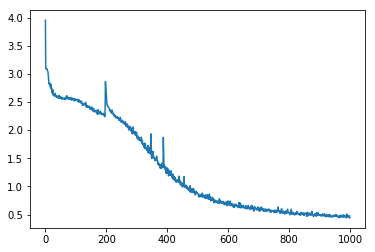

In [9]:
print('gpu name:',tf.test.gpu_device_name())
model_lstm = Sequential()

model_lstm.add(CuDNNGRU(100, input_shape=(4096,1), 
                        # regularizers.l1_l2(l1=0.01, l2=0.01), 
                        return_sequences=True))
model_lstm.add(CuDNNGRU(100,return_sequences=True))
model_lstm.add(CuDNNGRU(100))
# model_lstm.add(Dense(50, activation='relu'))
# model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

model_lstm.summary()

# Compile and fit model
model_lstm.compile(optimizer=Adam(lr=0.0005), loss="mae", metrics=['accuracy'])

# keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                    # kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                    # bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
                    # recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                    # kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
                    # recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, 
                    # go_backwards=False, stateful=False, unroll=False)


#model_lstm.add(
#                LSTM(100, input_shape=(4096,1), 
#                    kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False)
#              )

# model_lstm.add(BatchNormalization())

# model_lstm.add(Embedding(input_dim=4096, output_dim=224, input_length=None))
#model_lstm.add(LSTM(units=64))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(224))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(1, activation='linear'))

# model_lstm.add(LSTM(1, input_shape=(224,1), activation='linear', return_sequences=False))
# model_lstm.add(Dropout(0.2))
# model_lstm.add(LSTM(224, input_shape=(224,1), activation='linear', return_sequences=False))

#model_lstm.add(LSTM(224, input_shape=(4096,1), return_sequences=True))
#model_lstm.add(LSTM(224, input_shape=(224,1), return_sequences=True))
#model_lstm.add(LSTM(224, input_shape=(224,1), return_sequences=False))

# model_lstm.add(Flatten())
# model_lstm.add(Dropout(0.5))

# keras.layers.Dense(units, activation=None, 
#                    use_bias=True, 
#                    kernel_initializer='glorot_uniform', 
#                    bias_initializer='zeros', 
#                    kernel_regularizer=None, 
#                    bias_regularizer=None, 
#                    activity_regularizer=None, 
#                    kernel_constraint=None, 
#                   bias_constraint=None)

#model_lstm.add(Dense(224, input_dim=4096))
#model_lstm.add(Dense(224))
#model_lstm.add(Dense(1, activation='linear'))

#model_lstm.compile(loss='mean_squared_error', 
#                   optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),
#                   metrics=['accuracy'])  
#model_lstm.summary()

# checkpoint
# filepath="./data/train/weights3-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="./data/train/weights4-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             # monitor='val_acc', 
                             verbose=1, save_best_only=True
                             #, mode='max'
                            )
callbacks_list = [checkpoint]
# Fit the model

history = model_lstm.fit( 
                            X_train, 
                            y_train, 
                            epochs = 1000, 
                            validation_data = (X_test, y_test),
                            batch_size = 64,
                            callbacks=callbacks_list
                        )

plt.plot(history.history['loss'])

plt.savefig('./data/train/train.png')

# serialize model to JSON
model_json = model_lstm.to_json()
with open("model/model_lstm2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

model_lstm.save_weights("model/model_lstm3.h5")


(1, 2809) (1, 2809) (2809,)


Text(0, 0.5, 'Y_test_hat residuals')

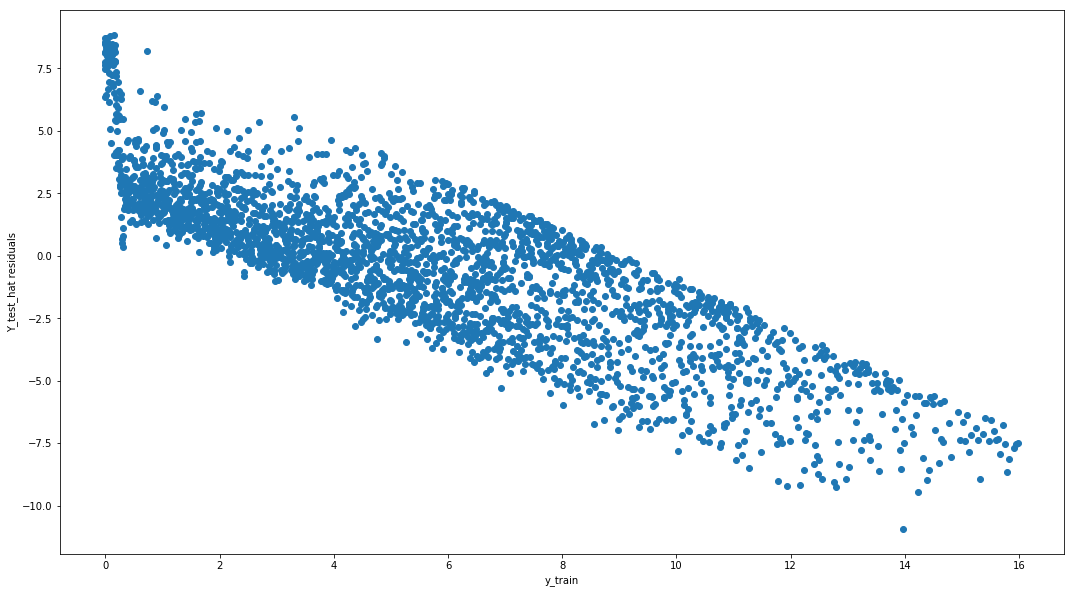

In [9]:
import matplotlib.gridspec as gridspec

Y_test_hat = model_lstm.predict(X_train)

Y_test_hat = np.reshape(Y_test_hat, (1,np.product(Y_test_hat.shape)))

residuals = np.subtract(Y_test_hat,y_train)

print(Y_test_hat.shape, residuals.shape, y_train.shape)

figure, axes1 = plt.subplots(figsize=(18,10))

plt.scatter(y_train, residuals)
plt.xlabel("y_train")
plt.ylabel("Y_test_hat residuals")



(2809,) (2809,) (1385,)


Text(0, 0.5, 'Y_test_hat residuals')

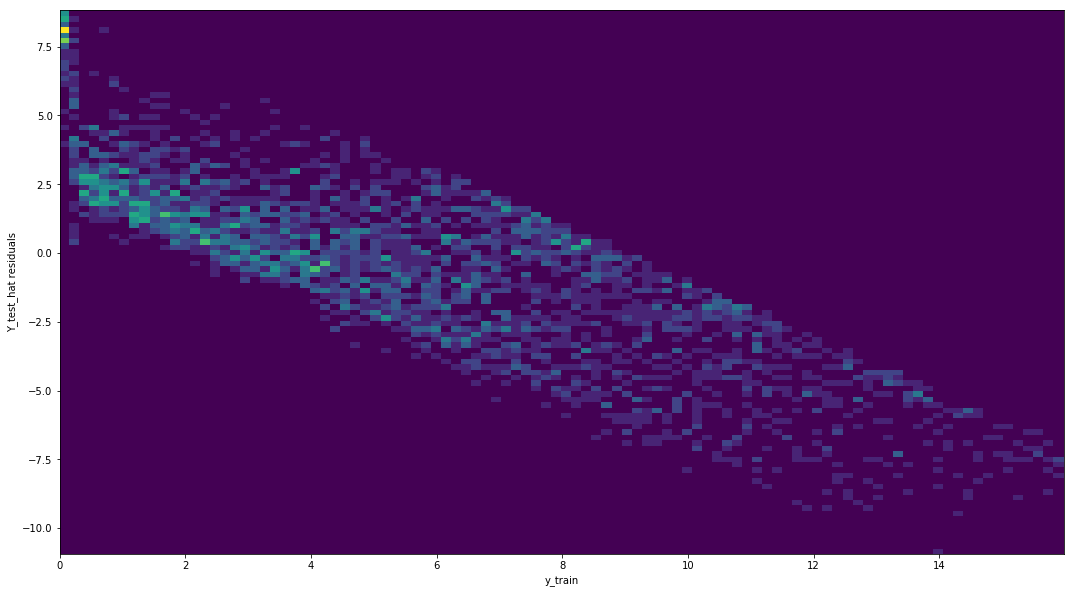

In [10]:
import matplotlib.gridspec as gridspec

Y_test_hat = model_lstm.predict(X_train)
y_test1 = np.reshape(y_train, (np.product(y_train.shape)))

Y_test_hat = np.reshape(Y_test_hat, (np.product(Y_test_hat.shape)))
residuals = np.subtract(Y_test_hat,y_test1)

print(Y_test_hat.shape, residuals.shape, y_test.shape)
figure, axes1 = plt.subplots(figsize=(18,10))
plt.hist2d(y_test1, residuals,100)
plt.xlabel("y_train")
plt.ylabel("Y_test_hat residuals")



## STOP

In [58]:
history = model_lstm.fit( 
                            X_train, 
                            y_train, 
                            epochs = 1000, 
                            validation_data = (X_test, y_test),
                            batch_size = 64,
                            callbacks=callbacks_list
                        )
plt.plot(history.history['loss'])

# serialize model to JSON
model_json = model_lstm.to_json()
with open("model/model_lstm2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm.save_weights("model/model_lstm2.h5")

#for layer in model_lstm.layers:
#    weights = layer.get_weights() # list of numpy arrays
#    print(weights)

Train on 2809 samples, validate on 1385 samples
Epoch 1/1000
2809/2809 [==============================] - 177s 63ms/step - loss: 43.4148 - acc: 0.0032 - val_loss: 46.0818 - val_acc: 0.0000e+00
Epoch 2/1000
2809/2809 [==============================] - 178s 63ms/step - loss: 43.4057 - acc: 0.0021 - val_loss: 41.5201 - val_acc: 0.0000e+00
Epoch 3/1000
2809/2809 [==============================] - 176s 63ms/step - loss: 43.2542 - acc: 0.0018 - val_loss: 42.4085 - val_acc: 0.0000e+00
Epoch 4/1000
2809/2809 [==============================] - 177s 63ms/step - loss: 43.1758 - acc: 0.0061 - val_loss: 41.6883 - val_acc: 0.0000e+00
Epoch 5/1000
2048/2809 [====================>.........] - ETA: 41s - loss: 43.2198 - acc: 0.0024

KeyboardInterrupt: 

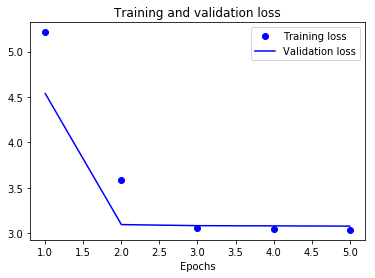

In [54]:
# plt.plot(history.history['loss'])

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    # return None

perf_plot(history)

In [8]:
# serialize model to JSON
# model_json = model_lstm.to_json()
# with open("model/model_lstm2.json", "w") as json_file:
#     json_file.write(model_json)
# serialize weights to HDF5
# model_lstm.save_weights("model/model_lstm2.h5")

# load json and create model
json_file = open('model/model_lstm2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_lstm = model_from_json(loaded_model_json)
# load weights into new model
model_lstm.load_weights("model/model_lstm2.h5")
model_lstm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
print("Loaded model from disk")


Loaded model from disk


In [40]:
# results = model_lstm.predict(X_test)
# plt.scatter(range(50),results,c='r')
# plt.scatter(range(50),y_test,c='g')
# plt.show()

scores = model_lstm.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))



# model_lstm2 = Sequential()
# model_lstm2.add(LSTM(224, input_shape=(4096, 1), return_sequences=True, implementation=2))
# model_lstm2.add(TimeDistributed(Dense(1)))
# model_lstm2.add(AveragePooling1D())

# model_lstm2.add(Flatten())

# model_lstm2.add(Dense(2, activation='softmax'))
# model_lstm2.compile(loss='mean_squared_error', optimizer='RMSprop',lr=.01)
# model_lstm2.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, validation_data=(X_test, y_test))


acc: 0.00%


# PREDICT ON TEST DATASET

In [3]:
test_path = "./data/test/"
test_files = glob.glob("./data/test/*.csv")
print(test_files[0:5])
len(test_files)
# sample_submission = pd.read_csv("./data/sample_submission.csv")
# Load submission file
submission = pd.read_csv('./data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

print(submission.head(10))
#len(submission.seg_id.values)

['./data/test/seg_40f810.csv', './data/test/seg_5bc0b0.csv', './data/test/seg_7df3dd.csv', './data/test/seg_9825e0.csv', './data/test/seg_e64dfa.csv']
            time_to_failure
seg_id                     
seg_00030f              0.0
seg_0012b5              0.0
seg_00184e              0.0
seg_003339              0.0
seg_0042cc              0.0
seg_004314              0.0
seg_004cd2              0.0
seg_004ee5              0.0
seg_004f1f              0.0
seg_00648a              0.0


In [3]:
for filename in tqdm(test_files):
    #print(filename)
    test = pd.read_csv(filename, dtype={'acoustic_data': np.int16})
    rows = 150_000

    seg = test
    x = seg['acoustic_data'].values

    fs = 1
    f, t, Sxx = signal.spectrogram(x, # array_like - Time series of measurement values
                               fs = fs, # float, optional - Sampling frequency of the x time series. Defaults to 1.0.
                               window = ('tukey', 0.25), # str or tuple or array_like, optional - Desired window to use. If window is a string or tuple, it is passed to get_window to generate the window values, which are DFT-even by default. See get_window for a list of windows and required parameters. If window is array_like it will be used directly as the window and its length must be nperseg. Defaults to a Tukey window with shape parameter of 0.25.
                               nperseg = 447, # int, optional - Length of each segment. Defaults to None, but if window is str or tuple, is set to 256, and if window is array_like, is set to the length of the window
                               noverlap = 113, # int, optional - Number of points to overlap between segments. If None, noverlap = nperseg // 8. Defaults to None.
                               nfft = None, # int, optional - Length of the FFT used, if a zero padded FFT is desired. If None, the FFT length is nperseg. Defaults to None.
                               detrend = 'constant', # str or function or False, optional - Specifies how to detrend each segment. If detrend is a string, it is passed as the type argument to the detrend function. If it is a function, it takes a segment and returns a detrended segment. If detrend is False, no detrending is done. Defaults to ‘constant’.
                               return_onesided = True, # bool, optional - If True, return a one-sided spectrum for real data. If False return a two-sided spectrum. Note that for complex data, a two-sided spectrum is always returned
                               scaling = 'density', # { ‘density’, ‘spectrum’ }, optional - Selects between computing the power spectral density (‘density’) where Sxx has units of V**2/Hz and computing the power spectrum (‘spectrum’) where Sxx has units of V**2, if x is measured in V and fs is measured in Hz. Defaults to ‘density’
                               axis = -1, # int, optional - Axis along which the spectrogram is computed; the default is over the last axis (i.e. axis=-1)
                               mode = 'psd' # str, optional - Defines what kind of return values are expected. Options are [‘psd’, ‘complex’, ‘magnitude’, ‘angle’, ‘phase’]. ‘complex’ is equivalent to the output of stft with no padding or boundary extension. ‘magnitude’ returns the absolute magnitude of the STFT. ‘angle’ and ‘phase’ return the complex angle of the STFT, with and without unwrapping, respectively
                              )
    # Returns:
    # f : ndarray - Array of sample frequencies.
    # t : ndarray - Array of segment times.
    # Sxx : ndarray - Spectrogram of x. By default, the last axis of Sxx corresponds to the segment times.

    logsxx = np.log(Sxx)

    # print(logsxx)
    # https://www.infobyip.com/detectmonitordpi.php
    my_dpi = 120
    fig = plt.figure(figsize=(t.shape[0]/my_dpi, f.shape[0]/my_dpi), dpi=my_dpi, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.yscale('log')

    plt.pcolormesh(t, f, logsxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0.01, 0.5)
    plt.savefig(filename.replace('.csv','.png'), dpi=my_dpi)
    plt.close(fig)



In [5]:
base_model = VGG16(weights='imagenet')
base_model.summary()
# # last fully connected layer before softmax (4096 parameters)
model = keras.models.Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)
# # last convolutional layer (52_584 parameters)
# # model = VGG16(weights='imagenet', include_top=False)

print("load model from json and weights from hdf5")
json_file = open('/shome/perrozzi/mlprojects/kaggle-lanl-earthquakes/data/model/model-triple_CuDNNGRU_reg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_lstm = model_from_json(loaded_model_json)
# print("Loaded model "+model_name+" from disk")
# load latest weights into new model
# list_of_files = glob.glob('./data/model/weights-'+model_name+"*.hdf5")
# if len(list_of_files)>0:
# latest_file = max(list_of_files, key=os.path.getmtime)
model_lstm.load_weights('/shome/perrozzi/mlprojects/kaggle-lanl-earthquakes/data/model/weights-triple_CuDNNGRU_reg-epoch102-val_loss2.084.hdf5')
# epoch_init = int(latest_file.split('epoch')[1].split("-")[0])
# print("loading weights from file",latest_file,"starting from epoch",epoch_init)

counter = 0
# test_files_png = glob.glob("./data/test/*.png")

if 1:
    # Load each test data, create the feature matrix, get numeric prediction
    for i, seg_id in enumerate(tqdm(submission.index)):
      #  print(i)
        # img_path = pd.read_csv('./data/test/' + seg_id + '.csv')
        # x = seg['acoustic_data'].values

        features_test = []

        counter = counter +1
        img_path = './data/test/' + seg_id + '.png'
        # print('img_path',img_path)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features_test.append( model.predict(x) )
        #y_list.append(y_resized2)

        df_test = pd.DataFrame(np.concatenate(features_test)).values
        # print(df_test.head(5))
        df_test = df_test.reshape((df_test.shape[0], df_test.shape[1], 1))

        # segment_test = filename.replace('./data/test/','').replace('.png','')
        segment_test = seg_id
        # print(segment_test)
        predict_x = model_lstm.predict(df_test)
        # print('segment_test',segment_test,'predict_x',predict_x[0][0])
        submission.time_to_failure[i] = predict_x[0][0]
        # print('submission.time_to_failure['+str(i)+']',submission.time_to_failure[i])

        #break

print(submission.head(100))
# Save
submission.to_csv('submission2_triple_CuDNNGRU_reg.csv')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


            time_to_failure
seg_id                     
seg_00030f         7.114591
seg_0012b5         8.051464
seg_00184e         8.004656
seg_003339         8.433558
seg_0042cc         8.148294
seg_004314         7.348341
seg_004cd2         8.017742
seg_004ee5         6.675242
seg_004f1f         8.383551
seg_00648a         7.835114
seg_006e4a         8.447703
seg_007a37         7.537352
seg_00a37e         7.885284
seg_00be11         8.035358
seg_00c35b         8.177035
seg_00cc91         8.582740
seg_00e5f7         8.426836
seg_00f3b9         8.089332
seg_010eab         7.873792
seg_0125d9         8.267087
seg_0144cb         8.438616
seg_0165c6         8.468863
seg_016913         8.493539
seg_016cdb         7.308638
seg_017314         7.330590
seg_01a8dc         8.358732
seg_01c775         8.648632
seg_01ecb0         8.133448
seg_02042f         8.540363
seg_025e78         8.260083
...                     ...
seg_075340         8.031860
seg_075f77         7.991226
seg_0775a7         

            time_to_failure
seg_id                     
seg_00030f         7.263712
seg_0012b5         5.432176
seg_00184e         6.638684
seg_003339         6.414876
seg_0042cc         6.302479
seg_004314         6.168516
seg_004cd2         7.514022
seg_004ee5         6.018983
seg_004f1f         6.092887
seg_00648a         6.306907
seg_006e4a         5.910056
seg_007a37         6.738306
seg_00a37e         5.627709
seg_00be11         6.472819
seg_00c35b         6.159860
seg_00cc91         7.607073
seg_00e5f7         6.039138
seg_00f3b9         6.952170
seg_010eab         7.232790
seg_0125d9         6.297178
seg_0144cb         7.211891
seg_0165c6         6.380906
seg_016913         6.016391
seg_016cdb         5.308164
seg_017314         5.724534
seg_01a8dc         6.328439
seg_01c775         6.339595
seg_01ecb0         6.220482
seg_02042f         5.671819
seg_025e78         5.061830
...                     ...
seg_075340         6.386982
seg_075f77         4.867688
seg_0775a7         5

# TEST MODELS

In [17]:
model_lstm = Sequential()
model_lstm.add( Bidirectional( LSTM( 4, 
                                    # input_shape = (1, 7, 7, 512), 
                                    input_shape = (1, 4096),
                                    # output_dim = 224, 
                                    return_sequences = True ) ) )
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(10)))
model_lstm.add(Dense(512, activation='relu'))
#model_lstm.add(Dropout(0.5))
#model_lstm.add(Dense(self.nb_classes))
#model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


# model_lstm2 = Sequential()  
# model_lstm2.add(LSTM(input_shape = (1, 4096), input_dim=1, output_dim=300, return_sequences=False))  
# model_lstm2.add(RepeatVector(10))
# model_lstm2.add(LSTM(output_dim=hidden_neurons, return_sequences=True))  
# model_lstm2.add(TimeDistributed(Dense(1)))
# model_lstm2.add(Activation('linear'))   
# model_lstm2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  

# model_lstm3 = Sequential()  
# model_lstm3.add(LSTM(input_shape = (1, 4096), output_dim=300, return_sequences=False))  
# model_lstm3.add(Dense(hidden_neurons, in_out_neurons))  
# model_lstm3.add(Activation("linear"))  
# model_lstm3.compile(loss="mean_squared_error", optimizer="rmsprop")


In [57]:
# LSTM(units, 
#     activation='tanh', 
#     recurrent_activation='hard_sigmoid', 
#     use_bias=True, 
#     kernel_initializer='glorot_uniform', 
#     recurrent_initializer='orthogonal', 
#     bias_initializer='zeros', 
#     unit_forget_bias=True, 
#     kernel_regularizer=None, 
#     recurrent_regularizer=None, 
#     bias_regularizer=None, 
#     activity_regularizer=None, 
#     kernel_constraint=None, 
#     recurrent_constraint=None, 
#     bias_constraint=None, 
#     dropout=0.0, 
#     recurrent_dropout=0.0, 
#     implementation=1, 
#     return_sequences=False, 
#     return_state=False, 
#     go_backwards=False, 
#     stateful=False, 
#     unroll=False)
model_lstm4 = Sequential()  
model_lstm4.add(LSTM([300], 300, return_sequences=True))  
model_lstm4.add(LSTM(300, 500, return_sequences=True))  
model_lstm4.add(Dropout(0.2))  
model_lstm4.add(LSTM(500, 200, return_sequences=False))  
model_lstm4.add(Dropout(0.2))  
model_lstm4.add(Dense(200, 3))  
model_lstm4.add(Activation("linear"))  
model_lstm4.compile(loss="mean_squared_error", optimizer="rmsprop")  


ValueError: ('Could not interpret activation function identifier:', 300)